In [1]:
import itertools
import pandas as pd
import numpy as np

from utils.loadData import loadData
from lstm.preprocessing import getDatasets, normalizeAtOnce
from lstm.model import getModel
from lstm.visualization import show_data_simple

np.random.seed(5)

In [2]:
df = loadData()

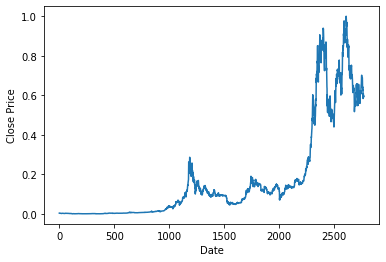

In [3]:
features = np.array(df["Close"]).reshape(-1, 1)
normalized_data, scaler = normalizeAtOnce(features)
show_data_simple(normalized_data)

In [8]:
def getModelBasicRegression(past, future, neurons):
  config = {
      "past": past,  
      "future": future,  
      "neurons": neurons,
      "batch_size": 128,  
      "epochs": 20,
      "features": 1
  }

  model = getModel(config)

  return model, config

In [12]:
def gridSearch(name):
  results = np.empty((0, 5))

  # define search space
  space = {
    "past": [10, 50, 100],
    "future": [10, 50],
    "neurons": [10, 50, 100]
  }

  pastFutureCombinations = list(itertools.product(space["past"], space["future"], space["neurons"])) # index 0 - past, 1 - future

  # loop through combinations of past and future
  for combination in pastFutureCombinations:
    tempResults = []
    # build each model 5 times and evaluate mean and std rmse
    for i in range(5):
      model, config = getModelBasicRegression(combination[0], combination[1], combination[2])
      
      dataset_train, dataset_val, _, _ = getDatasets(config, normalized_data)

      history = model.fit(
        dataset_train,
        epochs=config["epochs"],
        validation_data=dataset_val,
        verbose=0
      )

      rmse = min(history.history["val_rmse"])
      tempResults.append(rmse)

    # record the mean and std of the 5 iterations above for this combination of parameters. Record the combination parameters as well
    mean_std_stamp = np.array([np.mean(tempResults), np.std(tempResults), combination[0], combination[1], combination[2]]).reshape(-1)
    results = np.vstack((results, mean_std_stamp))

  # choose the best one
  indexBest = np.argmin(results[:, 0])
  print(f"Best parameters are: past - {results[indexBest][2]}, future - {results[indexBest][3]}, neurons - {results[indexBest][4]}")

  # Record results in a csv file
  df = pd.DataFrame(results, columns=["RMSE mean", "RMSE std", "past", "future", "nneurons"])
  df.to_csv(f"resultsGridSearch/{name}.csv")
  print("Done")

gridSearch("test")

Best parameters are: past - 10.0, future - 10.0, neurons - 10.0
Done


In [6]:
# run it in colab
# finally move on to webscraping and bertttttttttt omggg
# then that's it, just try some tricks, generalise experiments so noone asks me questions
# feature selection
# add more features
# after that that's basically it